In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit(nopython = True)
def RK4_2nd(d2ydt2, ti, tf,vi, yi, h):
    t = np.arange(ti, tf+h, h)
    y, v = 0*t, 0*t
    v[0], y[0] = vi, yi
    # y'' = f(x, y, y')
    # y' = g(x, y) = u
    # u' = f(x, y, u)
    # y' = g(x, y, u) = u
    F = lambda x, y, u: np.array([d2ydt2(x, y, u), u])
    for i in range(1, len(t)):
        k1 = F(t[i-1], y[i-1], v[i-1])
        k2 = F(t[i-1]+h/2, y[i-1]+k1[1]*h/2, v[i-1]+k1[0]*h/2)
        k3 = F(t[i-1]+h/2, y[i-1]+k2[1]*h/2, v[i-1]+k2[0]*h/2)
        k4 = F(t[i-1]+h, y[i-1]+k3[1]*h, v[i-1]+k3[0]*h)
        v[i], y[i] = np.array([v[i-1], y[i-1]]) + h/6*(k1+2*k2+2*k3+k4)
    return y, v

In [ ]:
def solve_langevin(U, lamda, sigma, N, t, x0=0, v0=0, a=None, dx = 0.01, reflective=True):
    dt = t[1] - t[0]
    # Random terms for stochastic dynamics
    noise_term = sigma*np.random.randn(len(t))/np.sqrt(dt)
    
    # Initial conditions
    pos = [x0]
    # vel = [2 * v0 * np.random.random(N) - v0]
    vel = [v0]
    
    # Runge-Kutta 4th Order Implementation
    for i, noise in enumerate(noise_term):
        xs = pos[-1]
        vxs = vel[-1]
        
        # Define total acceleration
        def acceleration(t, x, v):
            drag = -lamda * v
            force = -(U(x + dx) - U(x - dx)) / (2 * dx)
            return drag + force + noise
        
        # vector form of the differential equation
        F = lambda t, r: np.array([r[1], acceleration(t, r[0], r[1])])
        
        # runge kutta coef.
        r = np.array([pos[-1], vel[-1]])
        k1 = F(t[i-1], r)
        k2 = F(t[i-1]+dt/2, r+k1*dt/2)
        k3 = F(t[i-1]+dt/2, r+k2*dt/2)
        k4 = F(t[i-1]+dt, r+k3*dt)
        
        xs, vxs = r + dt/6*(k1+2*k2+2*k3+k4)
        
        # Boundary conditions: reflecting BC
        if reflective is True:
            if xs > a:
                vxs *= -1
                xs = 2 * a - xs
            if xs < -a:
                vxs *= -1
                xs = -2 * a - xs
            
        pos.append(xs)
        vel.append(vxs)
    vel = np.array(vel)
    pos = np.array(pos)
    return pos, vel

In [43]:
def pot(x, x01, x02, D0=50.5, a1=1.0, a2=1.0, coup=1.0):
    v1 = D0 * (1 - np.exp(-a1 * (x - x01)))**2
    f1 = 2 * D0 * (1 - np.exp(-a1 * (x - x01))) * np.exp(-a1 * (x - x01)) * a1

    v2 = D0 * (1 - np.exp(a2 * (x - x02)))**2
    f2 = -2 * D0 * (1 - np.exp(a2 * (x - x02))) * np.exp(a2 * (x - x02)) * a2

    diff = (v1 - v2) / np.sqrt((v1 - v2)**2 + 4 * coup**2)

    c1 = 1 / np.sqrt(2) * np.sqrt(1 - diff)
    c2 = 1 / np.sqrt(2) * np.sqrt(1 + diff)

    e1 = 0.5 * ((v1 + v2) - np.sqrt((v1 - v2)**2 + 4 * coup**2))
    g0 = c1**2 * f1 + c2**2 * f2

    return v1, v2, e1, f1, f2, g0

def U(x):
    # v1, v2, e1, f1, f2, g0 = pot(x, -0.5, 0.5)
    D0, a1, a2, x01, x02, coup = 50.5, 1.0, 1.0, -0.25, 0.25, 1.0
    v1 = D0 * (1 - np.exp(-a1 * (x - x01)))**2
    v2 = D0 * (1 - np.exp(a2 * (x - x02)))**2
    return 0.5*((v1 + v2) - np.sqrt((v1 - v2)**2 + 4 * coup**2))
temp = 2.2#0.75
damp = 10
dt = 1e-2
M = 100000
t = np.arange(0, (M + 1)*dt, dt)
pos, _ = solve_langevin(U=U, lamda=damp, sigma=np.sqrt(2*temp*damp), a=None, N=1, t=t, x0=0.2, dx=1e-3, reflective=False)

In [44]:
U(0.1)

0.709170494732462

In [45]:
def transition_rate(U, boundA, x_c, T, damp, dx=1e-3, type_='TST'):
    A = np.linspace(boundA[0], boundA[1], int((boundA[1] - boundA[0])/dx))
    if type(x_c) in [type(0), type(0.0)]: x_c = [x_c]
    
    # Boltzman constant
    k_B = 1.0
    
    # normalization with respect to the region A
    norm_A = 0
    pdf = 0
    
    for xa in A:
        norm_A += np.exp(-U(xa)/k_B/T)*dx
    
    count = 0
    for x in x_c:
        pdf += np.exp(-U(x)/k_B/T)
        count += 1
    pdf /= count

    if type_ == 'TST': return np.sqrt(T)*pdf/norm_A/np.sqrt(2*np.pi)
    if type_ == 'Kramers':
        w_b = np.mean([np.sqrt(-(U(x + dx) - 2*U(x) + U(x - dx))/dx/dx) for x in x_c])
        correction = 1/w_b*(-damp/2 + np.sqrt(w_b*w_b + damp*damp/4))
        return correction*np.sqrt(T)*pdf/norm_A/np.sqrt(2*np.pi)

In [46]:
print(f"TST rate = {transition_rate(U, [-0.5, 0.0], 0.0, 2.2, 10, dx=1e-3, type_='TST')}")
print(f"Kramers rate = {transition_rate(U, [-0.5, 0.0], 0.0, 2.2, 10, dx=1e-3, type_='Kramers')}")

TST rate = 0.8286275849567261
Kramers rate = 0.6102039246238821


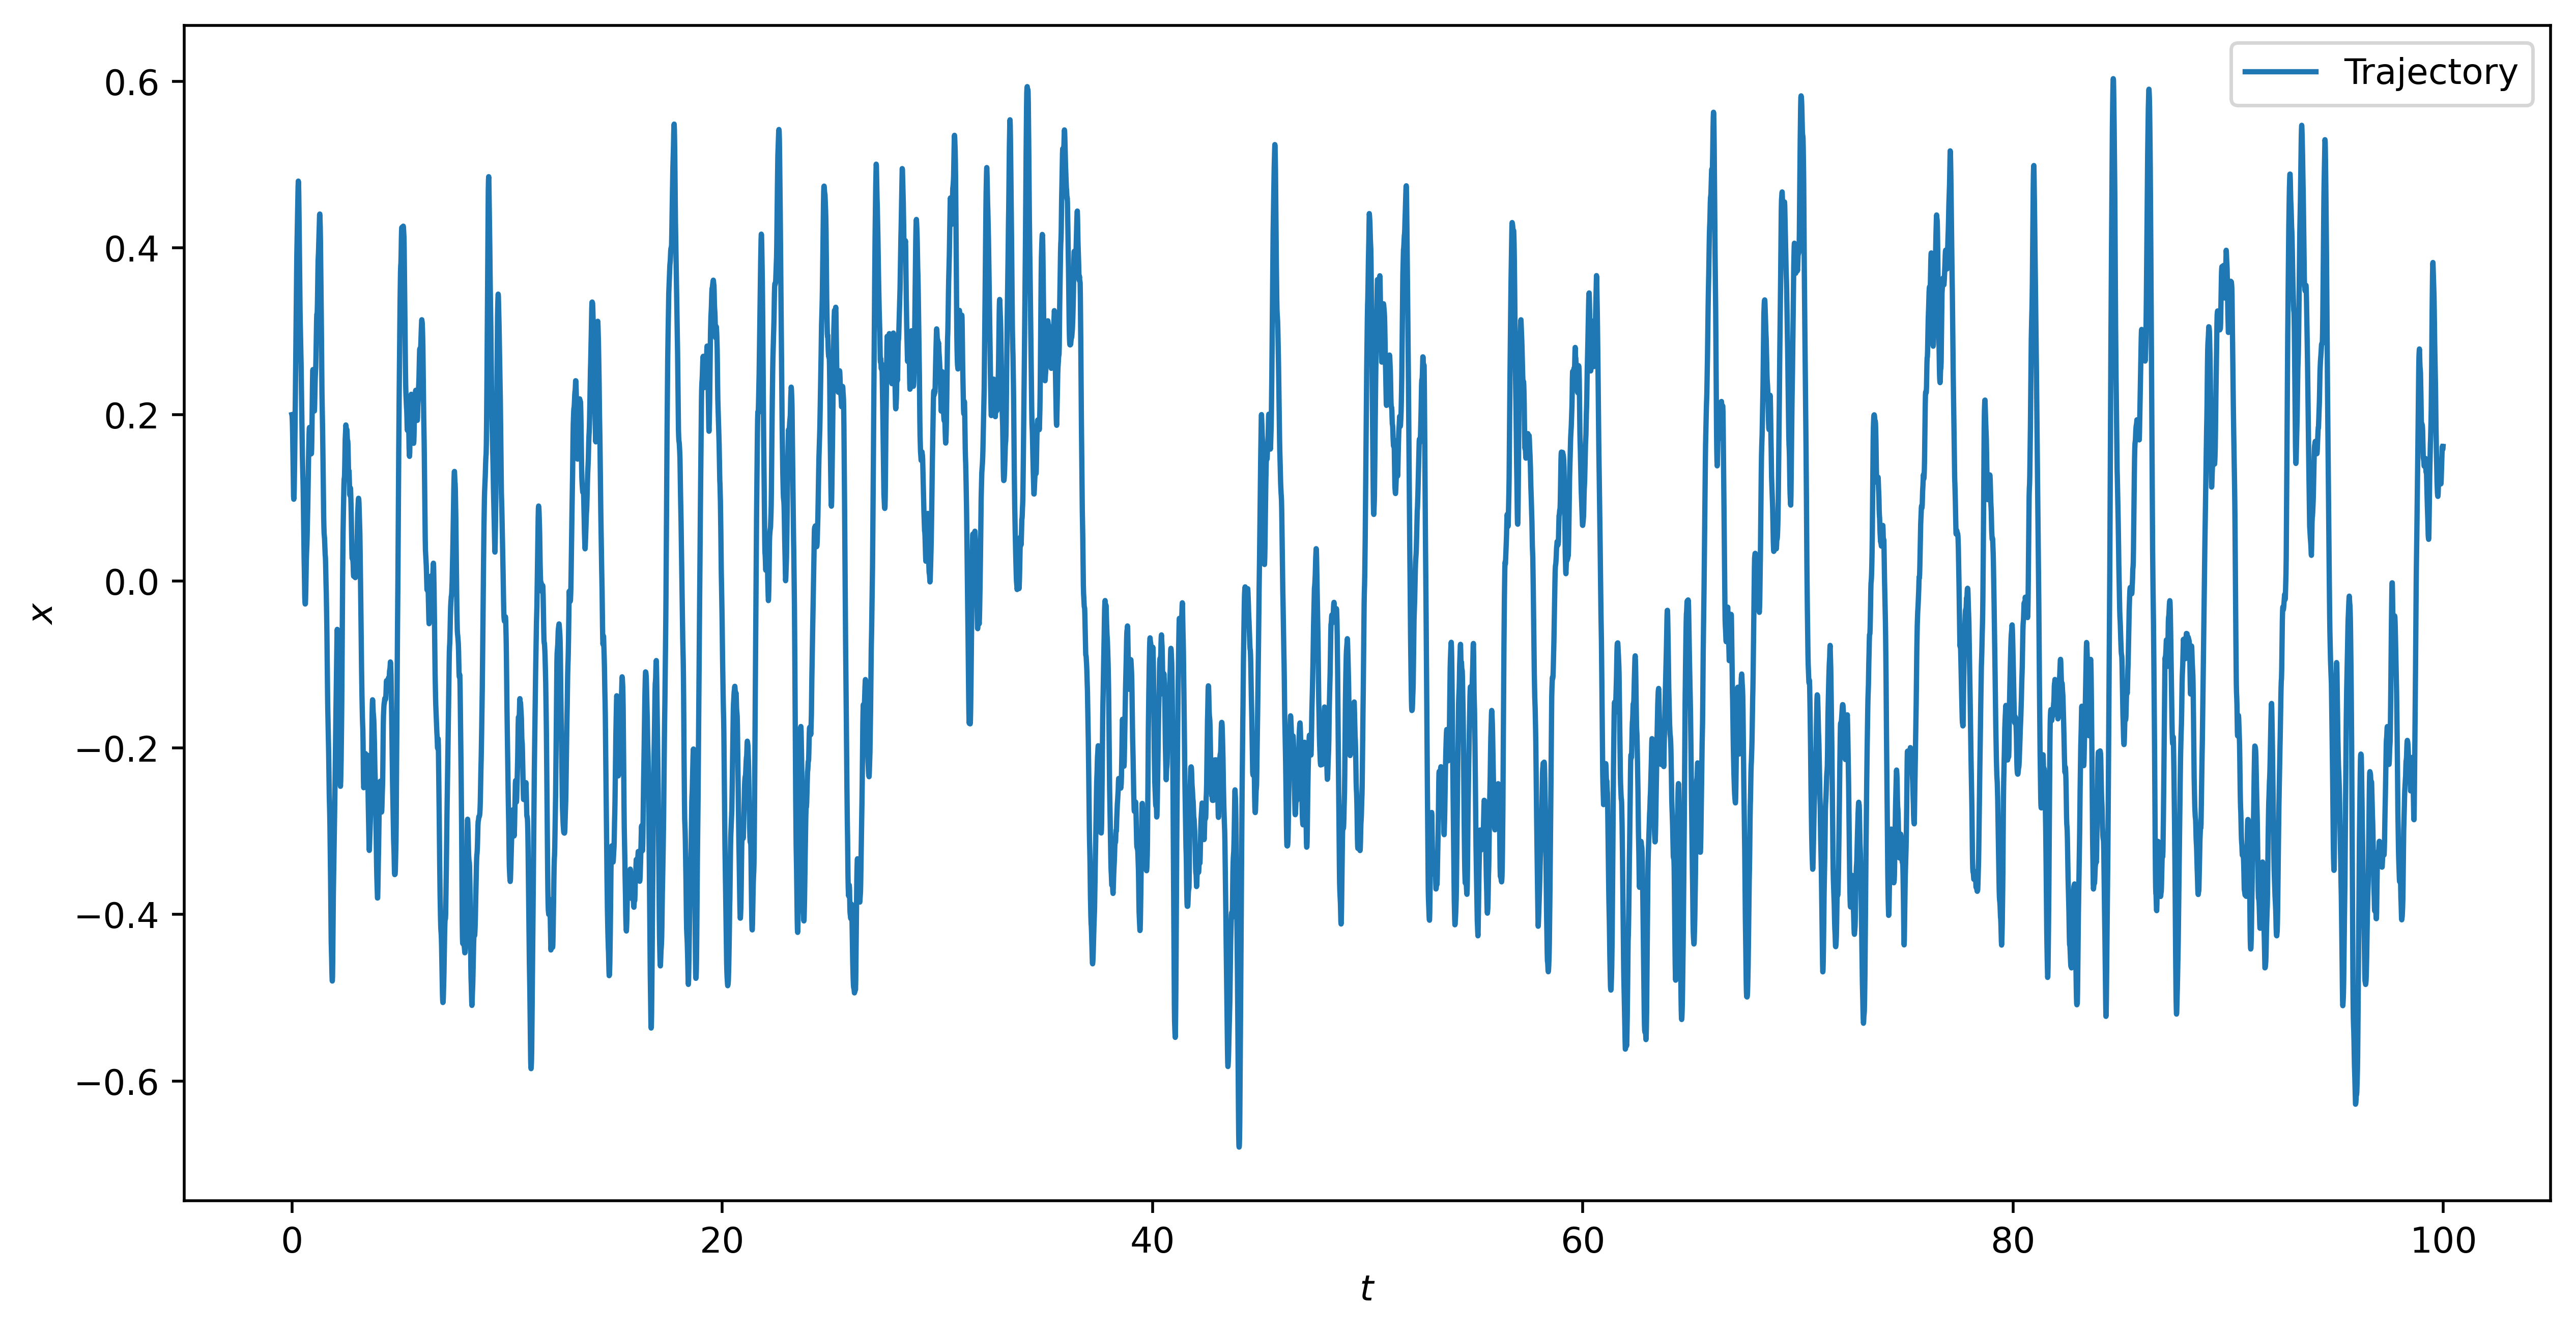

In [47]:
plt.figure(figsize=(12, 6), dpi=500)
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.plot(t[:10000], pos[:-1][:10000], label="Trajectory")
plt.legend()
plt.show()

In [48]:
def rate_num(time, trajectory):
    dt2 = time[1] - time[0]
    n_atob = 0
    na = np.sum(trajectory < 0)
    x_a = na/len(trajectory)
    nb = len(trajectory) - na
    flag = False
    for i in range(len(trajectory) - 6):
        if trajectory[i] < 0 and trajectory[i + 1] > 0:
            flag = True 
            if any(trajectory[i+j] < 0 for j in range(1, 6)): flag = False
            if flag: n_atob += 1
    return n_atob/(dt2*len(trajectory))/x_a if x_a > 0 else 0.0

In [56]:
rate_num(t[::], pos[::])

0.7613270611537509

In [57]:
pos

array([ 0.2       ,  0.19890136,  0.19449354, ..., -0.14178231,
       -0.13466742, -0.12526114])

In [58]:
print(rate_num(t[::50], pos[::50]))
print(transition_rate(U, [-0.5, 0.0], 0.0, 0.75, 0.1, dx=1e-3, type_='TST'))
print(transition_rate(U, [-0.5, 0.0], 0.0, 0.75, 0.1, dx=1e-3, type_='Kramers'))

0.1623309053069719
0.18233602948447647
0.1817702562814728


In [40]:
lambda0 = 0.1
lambda1 = 100
N = 50
temp = 0.75
lambdas = lambda0*np.power(lambda1/lambda0, np.linspace(0, 1, N))
rates_num = []
rates_Kramers = []
rates_TST = []
for damps in lambdas:
    pos, _ = solve_langevin(U=U, lamda=damps, sigma=np.sqrt(2*0.75*damps), a=None, N=1, t=t, x0=0.2, dx=1e-3, reflective=False)
    rates_num.append(rate_num(t[::50], pos[::50]))
    rates_TST.append(transition_rate(U, [-0.5, 0.0], 0.0, 0.75, damps, dx=1e-3, type_='TST'))
    rates_Kramers.append(transition_rate(U, [-0.5, 0.0], 0.0, 0.75, damps, dx=1e-3, type_='Kramers'))
    print(f"lambda = {damps}, rate = {rates_num[-1]} TST = {rates_TST[-1]} Kramers = {rates_Kramers[-1]}")

lambda = 0.1, rate = 0.030815709969788524 TST = 0.18233602948447647 Kramers = 0.1817702562814728
lambda = 0.11513953993264475, rate = 0.04243439419318817 TST = 0.18233602948447647 Kramers = 0.1816847543066753
lambda = 0.13257113655901093, rate = 0.043204320432043204 TST = 0.18233602948447647 Kramers = 0.18158635771757756
lambda = 0.15264179671752334, rate = 0.03245063523649166 TST = 0.18233602948447647 Kramers = 0.18147313061121723
lambda = 0.1757510624854792, rate = 0.04761032777879509 TST = 0.18233602948447647 Kramers = 0.18134284930084713
lambda = 0.2023589647725157, rate = 0.05411979325022803 TST = 0.18233602948447647 Kramers = 0.18119296047380487
lambda = 0.23299518105153721, rate = 0.06982543640897756 TST = 0.18233602948447647 Kramers = 0.18102053357700115
lambda = 0.26826957952797253, rate = 0.06919945725915876 TST = 0.18233602948447647 Kramers = 0.18082220673913035
lambda = 0.3088843596477481, rate = 0.06378600823045268 TST = 0.18233602948447647 Kramers = 0.1805941254936149
lam

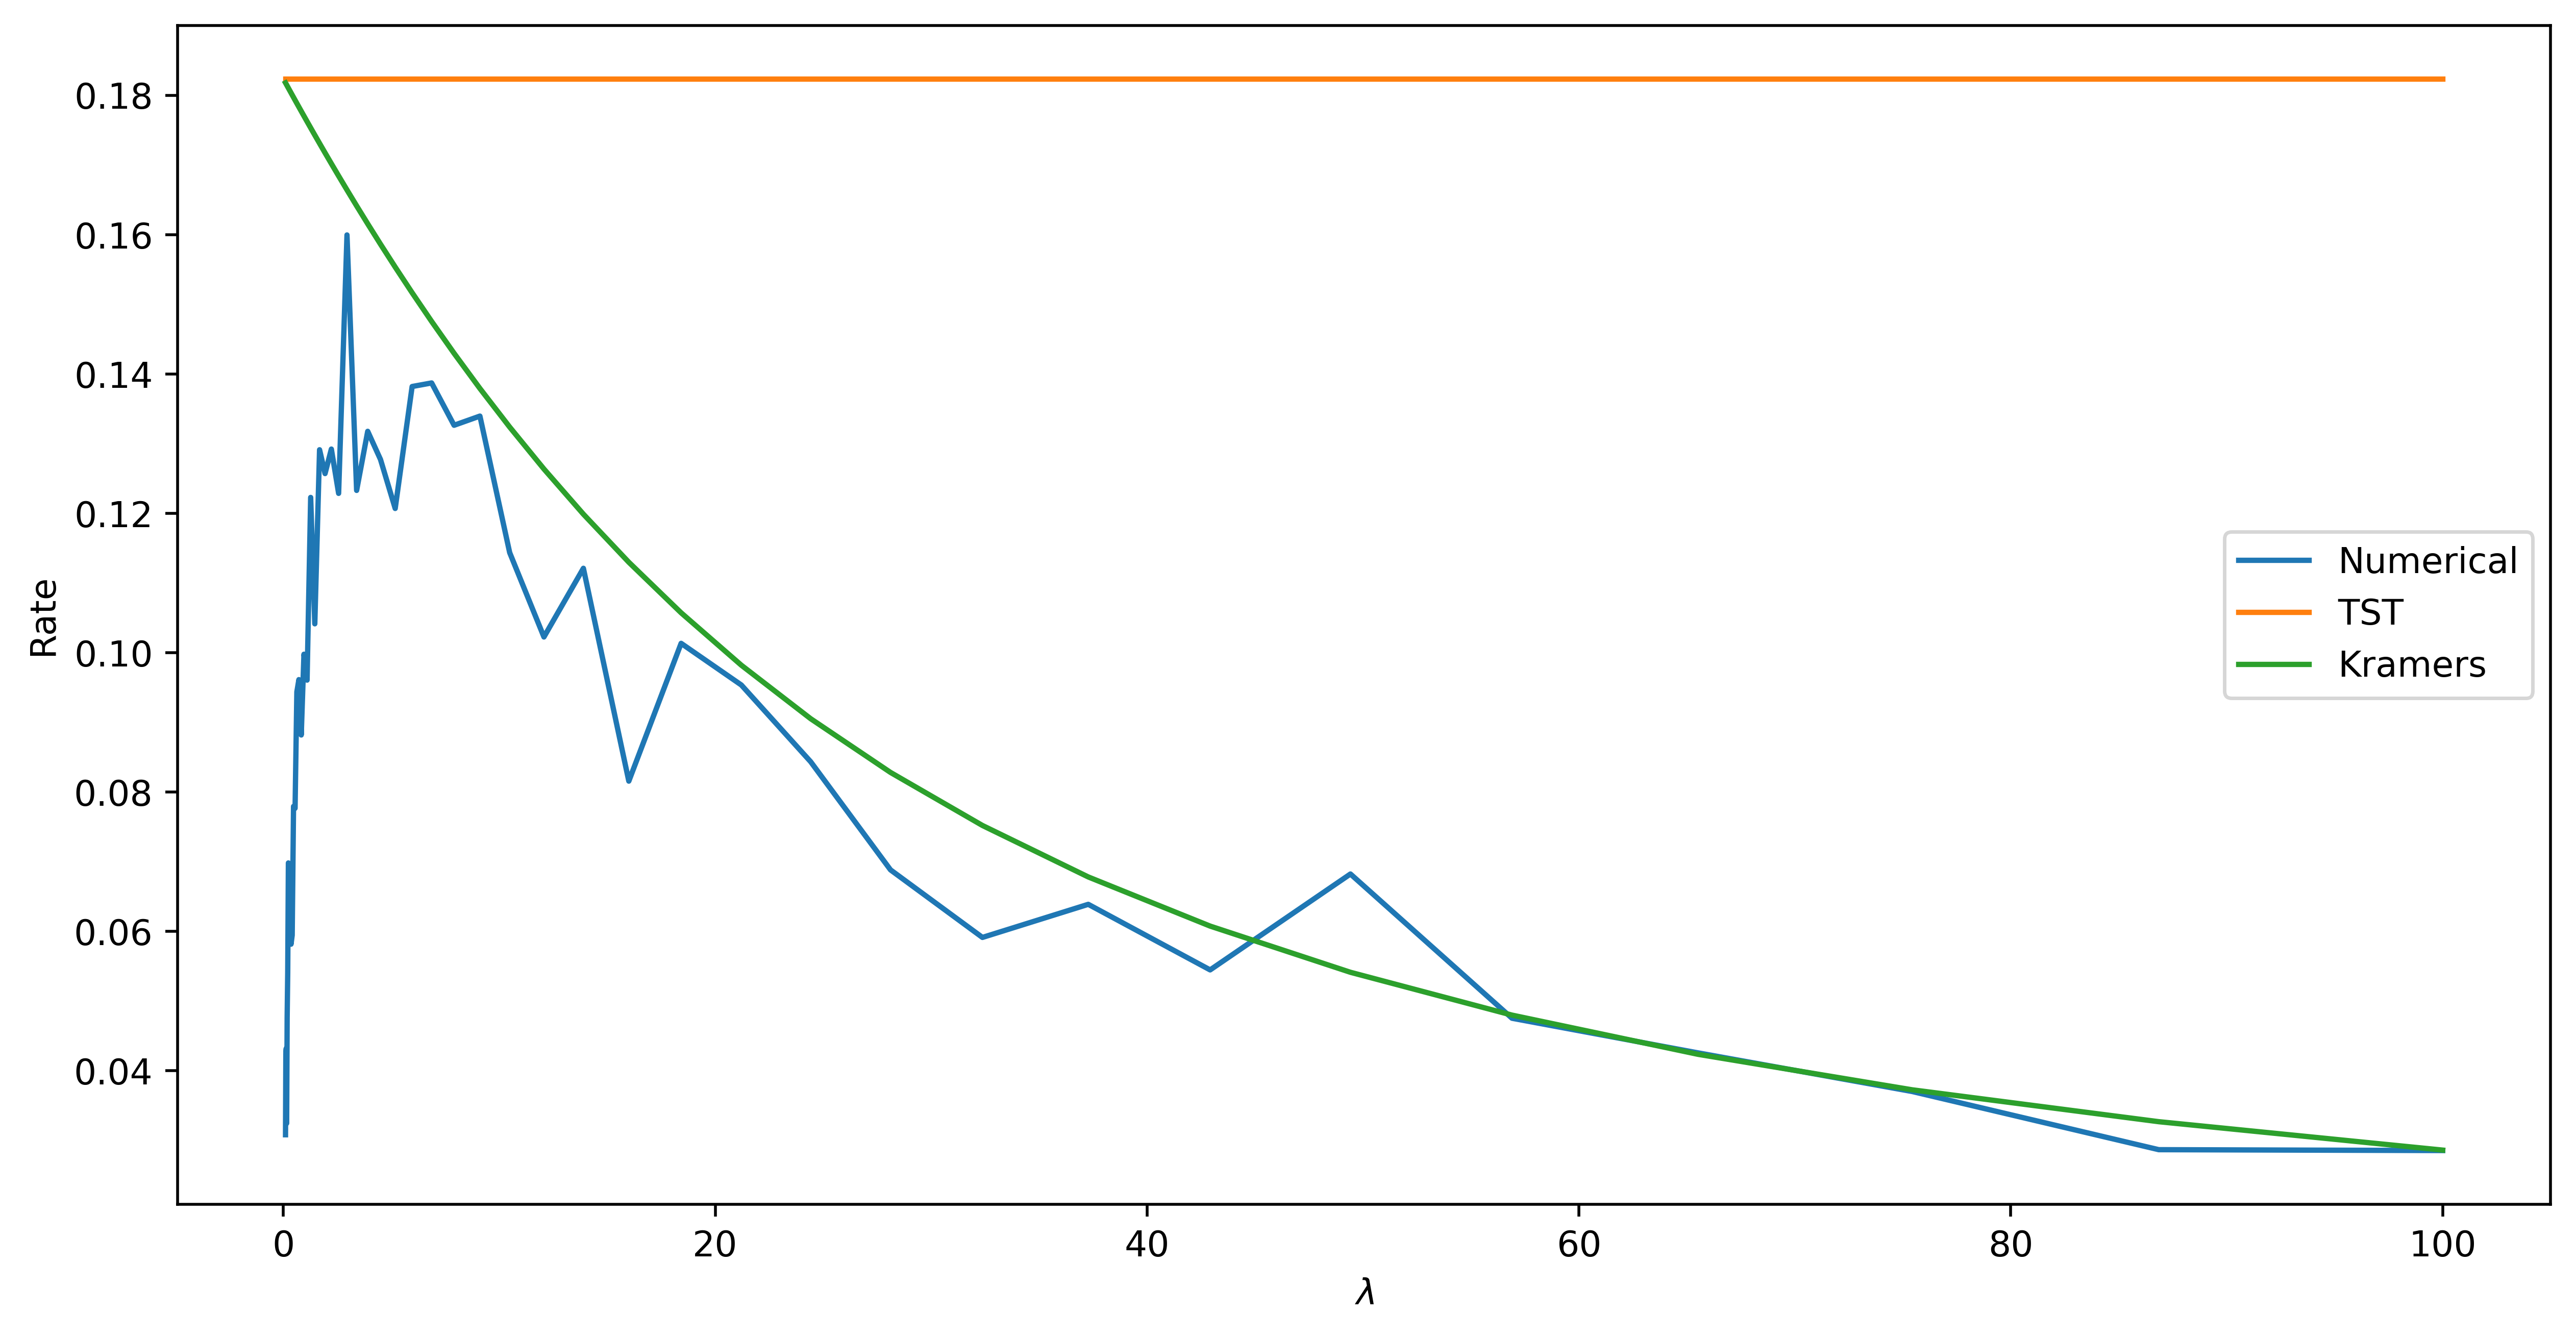

In [41]:
plt.figure(figsize=(12, 6), dpi=500)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"Rate")
plt.plot(lambdas, rates_num, label="Numerical")
plt.plot(lambdas, rates_TST, label="TST")
plt.plot(lambdas, rates_Kramers, label="Kramers")
plt.legend()
plt.show()

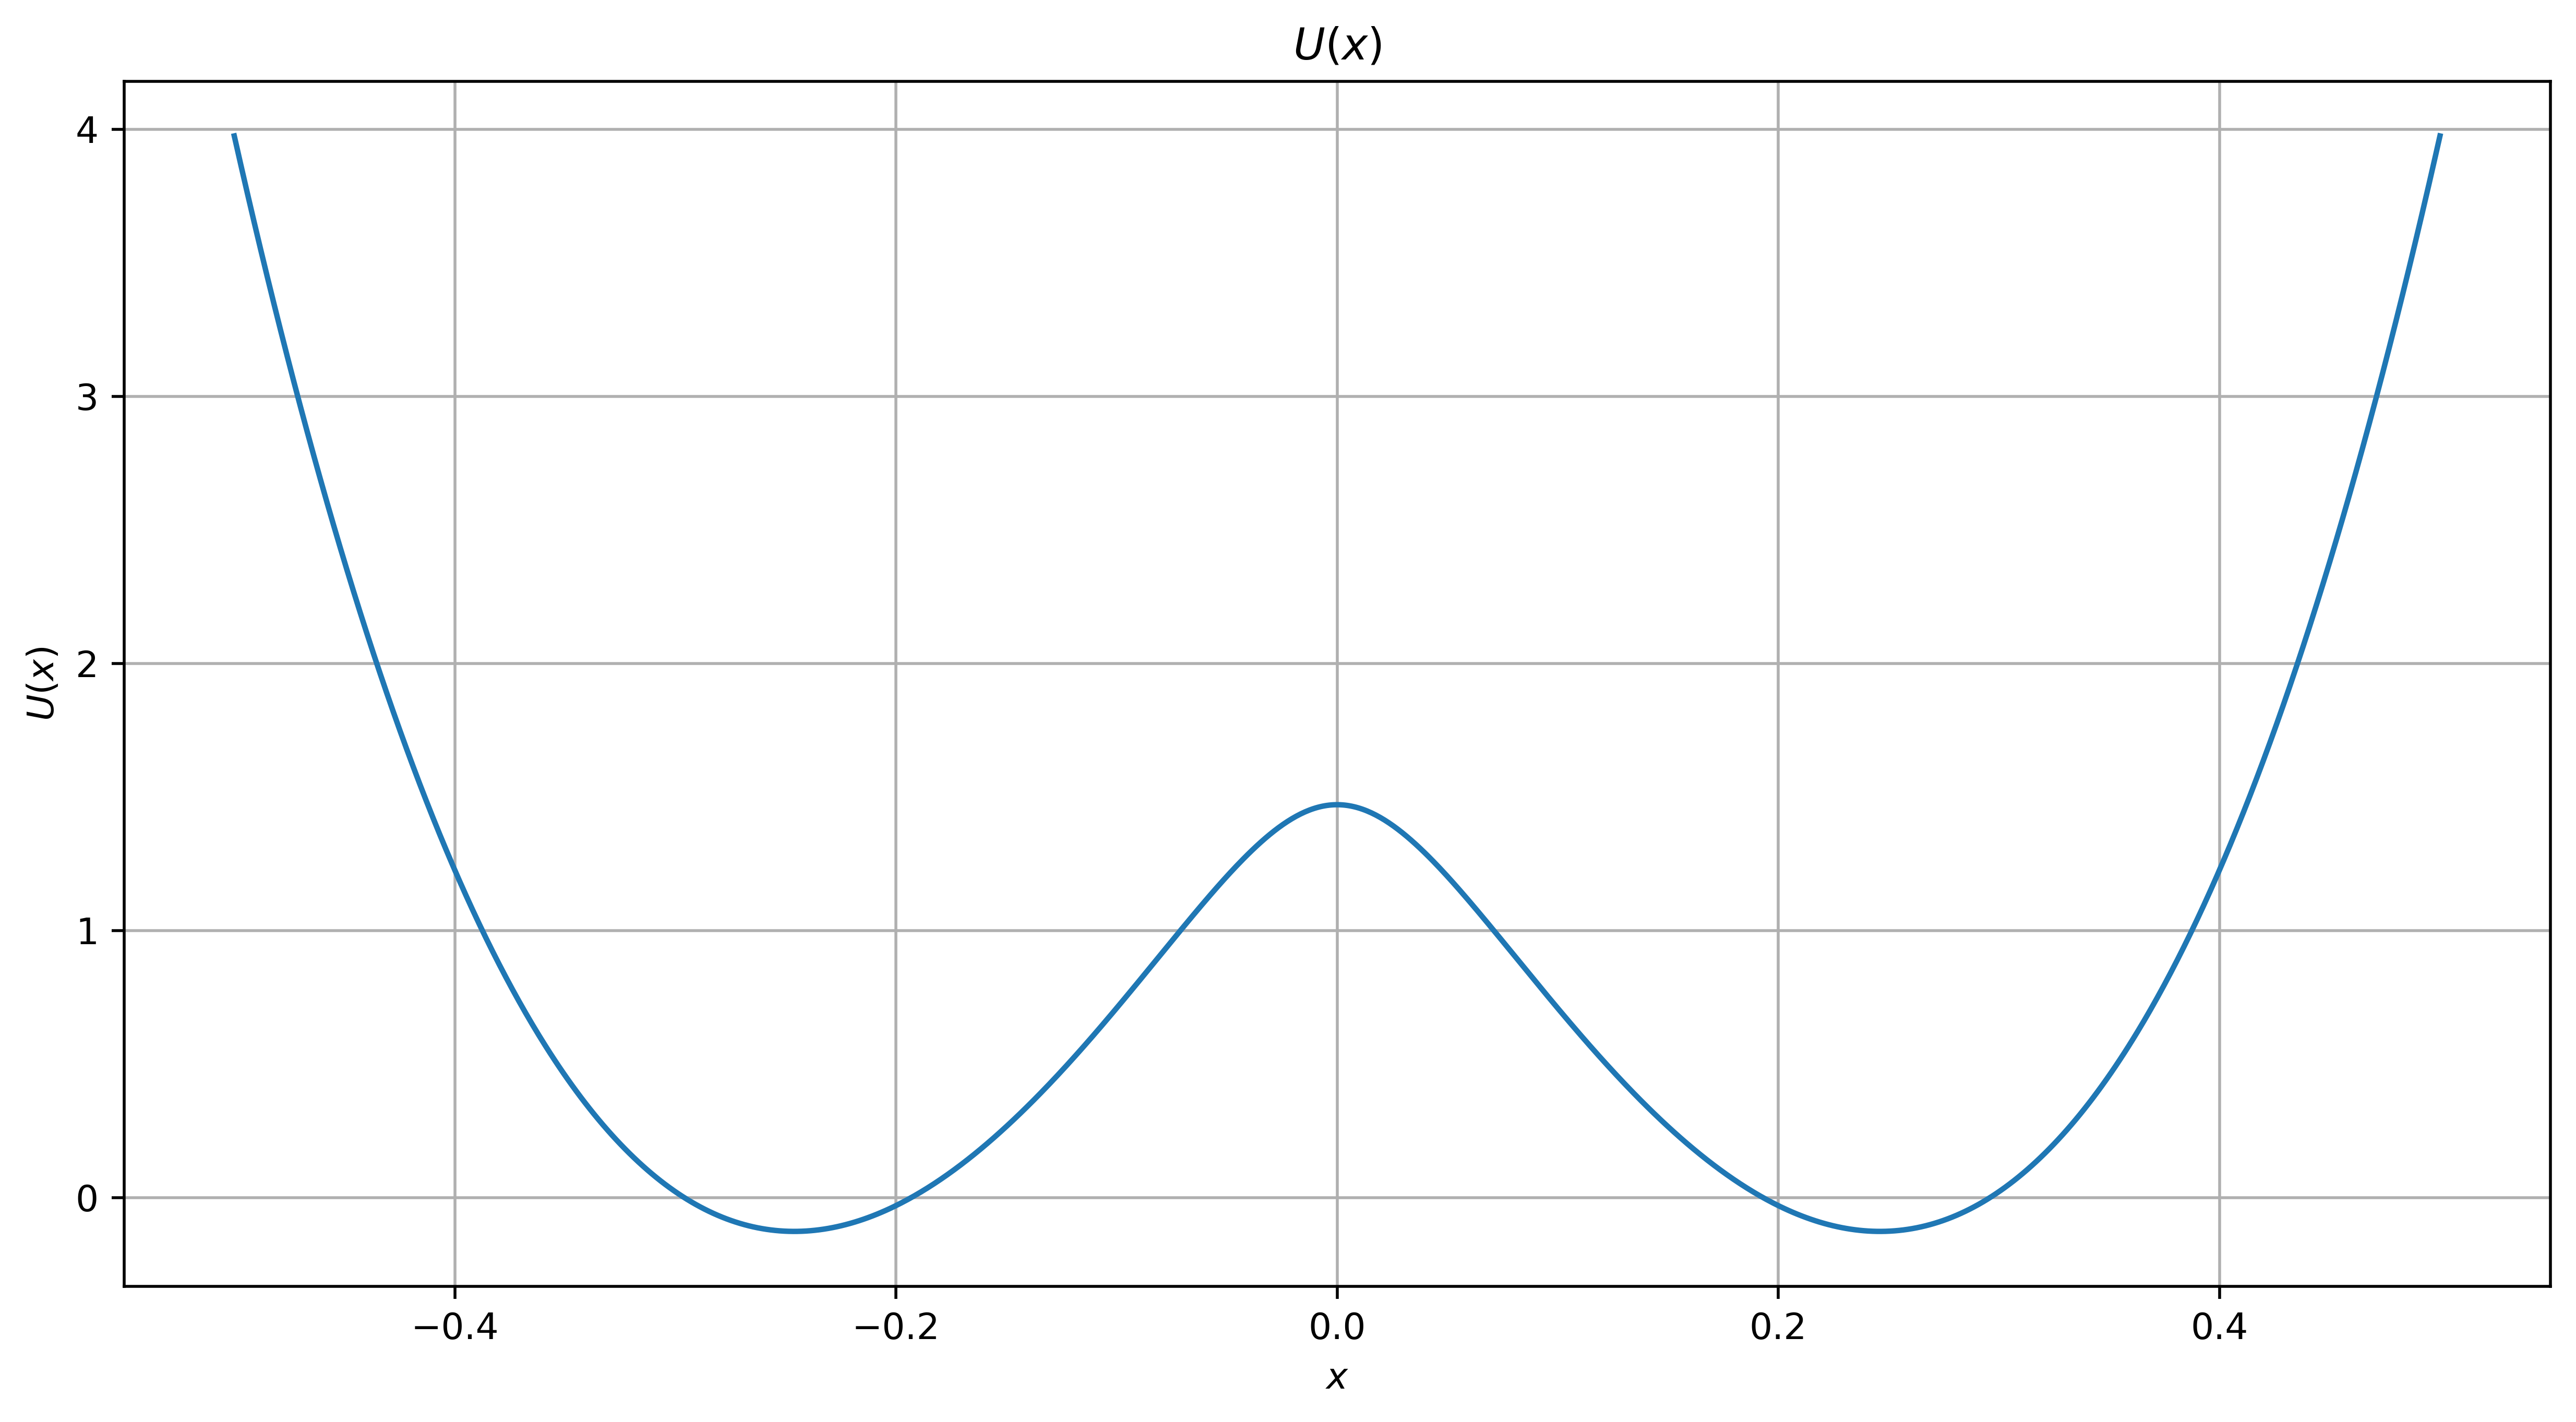

In [6]:
x_values = np.linspace(-.5, .5, 1000)
U_values = np.array([U(x) for x in x_values])

plt.figure(figsize=(12, 6), dpi=500)
plt.plot(x_values, U_values)
plt.title(r"$U(x)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$U(x)$")
plt.grid(True, 'both', 'both')
plt.show()